In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import pickle
import random

import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import functional as F

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
with open('../data/cifar-100-python/train', 'rb') as train_fp, \
    open('../data/cifar-100-python/meta', 'rb') as meta_fp:
    cifar_train = pickle.load(train_fp, encoding='bytes')
    cifar_meta = pickle.load(meta_fp, encoding='bytes')        

In [29]:
cifar_train.keys(), cifar_meta.keys()

(dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']),
 dict_keys([b'fine_label_names', b'coarse_label_names']))

In [32]:
len(cifar_train[b'filenames']), cifar_meta[b'fine_label_names'][cifar_train[b'fine_labels'][125]]

(50000, b'ray')

In [65]:
def show_cifar(idx, resize=False, size=(224, 224), interp=cv2.INTER_CUBIC):
    print(cifar_meta[b'fine_label_names'][cifar_train[b'fine_labels'][idx]])
    img = cifar_train[b'data'][idx].reshape((3, 32, 32)).transpose().swapaxes(0, 1)
    if resize and size:
        img = cv2.resize(img, size, interpolation=interp)
    plt.imshow(img)

b'ray'


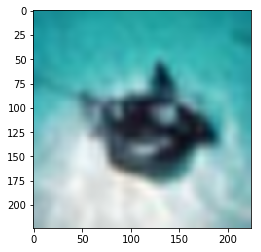

In [66]:
show_cifar(125, True)

In [96]:
train = pd.DataFrame(list(zip(cifar_train[b'data'], cifar_train[b'fine_labels'])), columns=['data', 'label'])

In [118]:
train.head()

,data,label
0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",19
1,"[255, 253, 253, 253, 253, 253, 253, 253, 253, ...",29
2,"[250, 248, 247, 248, 249, 249, 248, 248, 247, ...",0
3,"[124, 131, 135, 138, 140, 144, 148, 152, 156, ...",11
4,"[43, 32, 87, 127, 55, 48, 51, 87, 121, 113, 13...",1


In [115]:
ncores = 8

In [98]:
images = dd.from_pandas(train['data'], npartitions=ncores*2)

In [114]:
res = images.apply(lambda x: cv2.resize(x.reshape((3, 32, 32)).transpose().swapaxes(0, 1),
                                        (224, 224), interpolation=cv2.INTER_CUBIC), meta=images)

In [117]:
loader = torch.utils.data.DataLoader(res, batch_size=ncores*4, shuffle=False, num_workers=ncores*2)

In [120]:
model_name = 'densenet121'
layer_name = 'features'

get_model = getattr(torchvision.models, model_name)

def extract_features(loader):

    model = get_model(pretrained=True)
    model = model.cuda()
    model.eval()

    # register hook to access to features in forward pass
    features = []
    def hook(module, input, output):
        N,C,H,W = output.shape
        output = output.reshape(N,C,-1)
        features.append(output.mean(dim=2).cpu().detach().numpy())
    handle = model._modules.get(layer_name).register_forward_hook(hook)

    for i_batch, inputs in tqdm(enumerate(loader), total=len(loader)):
        _ = model(inputs.cuda())

    features = np.concatenate(features)
    
    handle.remove()
    del model

    return features